In [1]:
import os
import tqdm
import torch
import nequip
import math
from nequip.ase import NoseHoover

import ase
from ase import Atoms
from ase.io import read, write, Trajectory
from nequip.ase import NequIPCalculator

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from ase.md import MDLogger
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase.md.nvtberendsen import NVTBerendsen

ModuleNotFoundError: No module named 'torch'

## Running test MD

In [2]:
BASE_PATH = "/usr/workspace/dsk-jv/trained_models/nequip"

calc = NequIPCalculator.from_deployed_model(f"{BASE_PATH}/2layer/deployed.pth", device="cuda:1")

/usr/workspace/dskoda/envs/torch-coral/lib/python3.8/site-packages/nequip/utils/_global_options.py:58: UserWarning: Setting the GLOBAL value for jit fusion strategy to `[('DYNAMIC', 3)]` which is different than the previous value of `[('STATIC', 2), ('DYNAMIC', 10)]`
  warnings.warn(
/usr/workspace/dskoda/envs/torch-coral/lib/python3.8/site-packages/nequip/ase/nequip_calculator.py:73: UserWarning: Trying to use chemical symbols as NequIP type names; this may not be correct for your model! To avoid this warning, please provide `species_to_type_name` explicitly.
  warnings.warn(


In [3]:
xyz = read("/usr/workspace/dsk-jv/mace/datasets/3BPA_500.xyz", index=":")

In [4]:
energies = [at.info["energy"] for at in xyz]
atoms = [at for at in xyz if at.info["energy"] == min(energies)][0].copy()
atoms.set_calculator(calc)

In [5]:
write("/usr/workspace/dsk-jv/nequip/md/3BPA_min.xyz", atoms)

In [5]:
# dyn = VelocityVerlet(atoms, timestep=2*ase.units.fs)

In [6]:
# temperature = 1200 # Kelvin
# timestep = 1 * ase.units.fs

# Q = (3 * len(atoms) - 6) #* ase.units.kB * temperature * timestep ** 2 / (2 * math.pi ** 2)

# dyn = NoseHoover(
#     atoms,
#     timestep=1 * ase.units.fs,
#     temperature=1200,
#     nvt_q=Q,
#     trajectory="3BPA.traj",
# #     taut=0.5*1000*ase.units.fs
# )

In [41]:
temperature = 600 # Kelvin
timestep = 2 * ase.units.fs
taut = 0.5 * 500 * ase.units.fs

dyn = NVTBerendsen(
    atoms,
    timestep=timestep,
    temperature_K=temperature,
    taut=taut,
    trajectory="3BPA.traj",
)

In [11]:
# temperature = 1200 # Kelvin
# timestep = 1 * ase.units.fs
# friction = 1e-3

# dyn = Langevin(
#     atoms,
#     timestep=timestep,
#     temperature_K=temperature,
#     friction=friction,
#     trajectory="3BPA.traj",
# )

In [42]:
dyn.attach(MDLogger(
    dyn,
    atoms,
    '3BPA.log',
    header=True,
    stress=False,
    peratom=True,
    mode="a"
), interval=3)

In [43]:
dyn.run(1000)

True

## Analyzing the trajectory

In [2]:
from ase.geometry.analysis import Analysis

In [3]:
def get_edge_list(atoms):
    an = Analysis(atoms)
    edge_list = []
    for i, bonds in enumerate(an.all_bonds[0]):
        for j in bonds:
            edge_list.append([i, j])

    return np.array(edge_list)

def get_distances(atoms, edge_list=None):
    dm = atoms.get_all_distances()
    if edge_list is None:
        return dm
    
    return dm[edge_list[:, 0], edge_list[:, 1]]    

In [5]:
def get_explosion_index(traj):
    edges = get_edge_list(traj[0])
    
    max_dists = np.array([
        get_distances(at, edges).max()
        for at in traj
    ])
    index = np.argwhere(max_dists > 2).flat
    if len(index) == 0:
        return len(traj)
    
    return index[0]

## Analyzing all trajectories

In [1]:
import os
import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PATHS = [f"/usr/WS2/dsk-jv/nequip/md/runs-{f}" for f in ["3", "3-2", "3-3"]]

traj_files = sorted([
    os.path.join(_path, f)
    for _path in PATHS
    for f in os.listdir(_path)
    if f.endswith(".json")
])

In [3]:
results = []

for _json in tqdm.tqdm(traj_files):
    with open(_json, "r") as f:
        traj = json.load(f)
        
    model, i = _json.split("/")[-1].replace(".json", "").split("-")
    traj["model"] = model
    traj["num"] = int(i)

    results.append(traj)

100%|██████████| 390/390 [00:00<00:00, 981.03it/s]


In [4]:
df = pd.DataFrame(results)

In [5]:
df.to_csv("nequip_explosion.csv")

In [6]:
df["model"].unique()

array(['2layer_yes_rescaling_no_amsgrad_no_ema',
       '2layer_yes_rescaling_no_amsgrad_yes_ema',
       '2layer_yes_rescaling_yes_amsgrad_no_ema',
       '5layer_yes_rescaling_no_amsgrad_no_ema',
       '5layer_yes_rescaling_no_amsgrad_yes_ema',
       '5layer_yes_rescaling_yes_amsgrad_no_ema', '2layer', '3layer',
       '4layer', '5layer', 'baseline', 'non_trainable_bessel',
       'rescaling'], dtype=object)

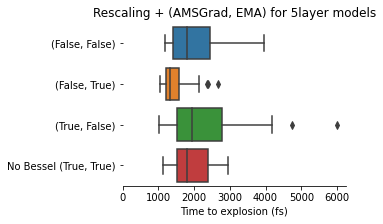

In [23]:
fig, ax = plt.subplots(figsize=(4, 3))

_models = {
    '5layer_yes_rescaling_no_amsgrad_no_ema': "(False, False)",
    '5layer_yes_rescaling_no_amsgrad_yes_ema': "(False, True)",
    '5layer_yes_rescaling_yes_amsgrad_no_ema': "(True, False)",
    '2layer': "No Bessel (True, True)"
}
_df = df.loc[df["model"].isin(_models.keys())]

ax = sns.boxplot(
    data=_df,
    x="explosion",
    y="model",
    ax=ax,
)

ax.set_xlabel("Time to explosion (fs)")
ax.set_ylabel("")

ax.set_xlim(0)

for sp in ["left", "right", "top"]:
    ax.spines[sp].set_visible(False)

labels = [_models[t.get_text()] for t in ax.get_yticklabels()]
ax.set_yticklabels(labels)

ax.set_title("Rescaling + (AMSGrad, EMA) for 5layer models")
plt.show()

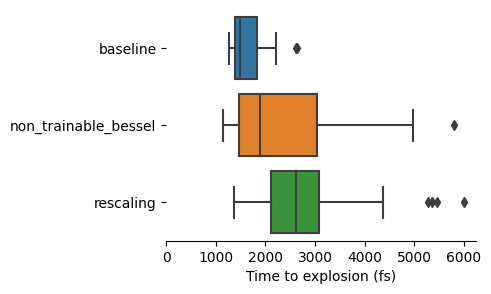

In [42]:
fig, ax = plt.subplots(figsize=(4, 3))

_df = df.loc[df["model"].isin(["baseline", 'non_trainable_bessel', 'rescaling'])]

ax = sns.boxplot(
    data=_df,
    x="explosion",
    y="model",
    ax=ax,
)

ax.set_xlabel("Time to explosion (fs)")
ax.set_ylabel("")

ax.set_xlim(0)

for sp in ["left", "right", "top"]:
    ax.spines[sp].set_visible(False)

plt.show()

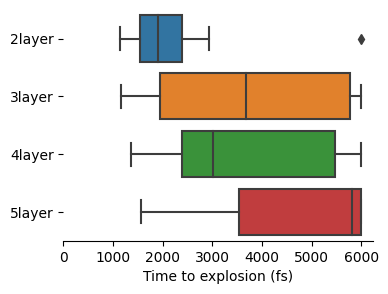

In [43]:
fig, ax = plt.subplots(figsize=(4, 3))

_df = df.loc[df["model"].isin([f"{i}layer" for i in range(2, 6)])]

ax = sns.boxplot(
    data=_df,
    x="explosion",
    y="model",
    ax=ax,
)

ax.set_xlabel("Time to explosion (fs)")
ax.set_ylabel("")

ax.set_xlim(0)

for sp in ["left", "right", "top"]:
    ax.spines[sp].set_visible(False)

plt.show()

In [35]:
df

,model,num,explosion
0,2layer,1,1499
1,2layer,2,2824
2,2layer,3,2025
3,2layer,4,2127
4,2layer,5,1690
...,...,...,...
205,rescaling,26,2134
206,rescaling,27,2669
207,rescaling,28,5265
208,rescaling,29,2526
